In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from transformers import AutoTokenizer, BertTokenizer, TFAutoModel, TFBertModel
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold,train_test_split
import os

os.environ["WANDB_API_KEY"] = "0"

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


# Data Overview and EDA

In [4]:
df_train = pd.read_csv('../input/contradictory-my-dear-watson/train.csv')
df_test = pd.read_csv('../input/contradictory-my-dear-watson/test.csv')

In [3]:
df_train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [4]:
df_train.isnull().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
label         0
dtype: int64

In [5]:
df_test.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [6]:
df_test.isnull().sum()

id            0
premise       0
hypothesis    0
lang_abv      0
language      0
dtype: int64

No null values in both train and test data

Text(0.13, 0.95, 'Train vs Test: Language Count')

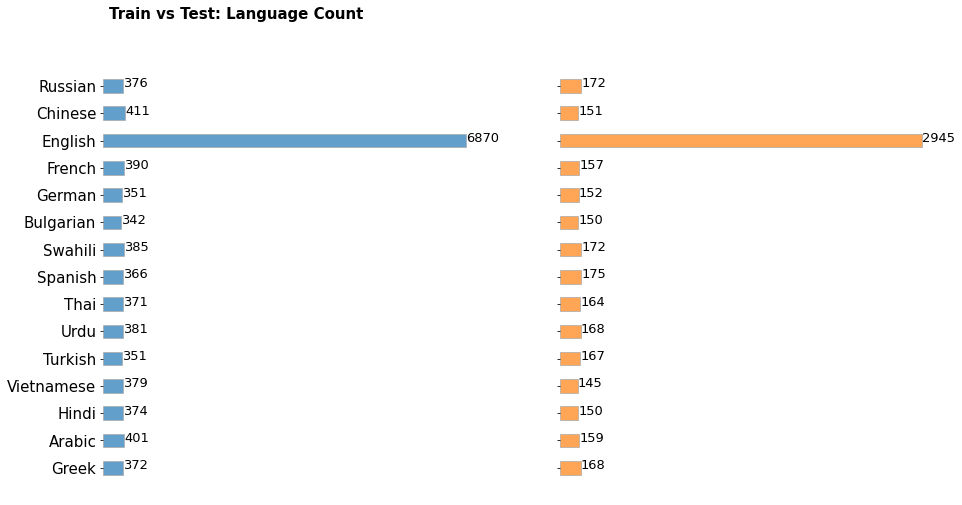

In [7]:
train_language_cnt = df_train['language'].value_counts(sort=False)
test_language_cnt = df_test['language'].value_counts(sort=False)[train_language_cnt.index]
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(15,8),sharey=True)
for i,cnt in enumerate([train_language_cnt,test_language_cnt]):
    axes[i].barh(cnt.index,cnt.values,
            height=0.5, edgecolor='darkgrey',
            color=sns.color_palette()[i],alpha=0.7)
    axes[i].set_yticklabels(cnt.index,fontsize=15)
    axes[i].set_xticks([])

    for j in axes[i].patches:
        axes[i].text(j.get_width()+.5, j.get_y()+.2,
                str(j.get_width()), 
                fontsize=13, color='black')

    for pos in ['left','right','bottom','top']:
        axes[i].spines[pos].set_color(None)

    #axes[i].grid(axis='x',linestyle='-',alpha=0.4)
    #axes[i].invert_yaxis()
fig.text(0.13, 0.95, 'Train vs Test: Language Count', fontsize=15, fontweight='bold') 

English take the dominant place in both train and test data.

In [8]:
label_cnt = df_train['label'].value_counts()
trace = go.Pie(labels = label_cnt.index, 
               values = label_cnt.values,
               hoverinfo = 'percent+value+label',
               textinfo = 'percent',
               textposition = 'inside',
               textfont = dict(size=14),
               title = 'Label',
               titlefont = dict(size=15),
               hole = 0.3,
               showlegend = True,
               marker = dict(line=dict(color='black',width=2)))
fig = go.Figure(data=[trace])
fig.update_layout(height=500, width=500)
fig.show()

In [10]:
fig = make_subplots(rows=5, cols=3, specs=[[{"type": "domain"}]*3]*5,
                    horizontal_spacing=0.005,vertical_spacing=0.01)
for i,lang in enumerate(list(train_language_cnt.index)): 
    label_cnt = df_train[df_train.language == lang]['label'].value_counts()
    fig.add_trace(go.Pie(labels = label_cnt.index, 
                   values = label_cnt.values,
                   hoverinfo = 'percent+value+label',
                   textinfo = 'percent',
                   textposition = 'inside',
                   textfont = dict(size=14),
                   title = lang,
                   titlefont = dict(size=15),
                   hole = 0.5,
                   showlegend = True,
                   marker = dict(line=dict(color='black',width=2))),
                   row=divmod(i,3)[0]+1,col=divmod(i,3)[1]+1)
fig.update_layout(height=750, width=750)
fig.show()

The distribution of train labels is quite balanced on the whole and in differnt languages.

Text(0.13, 0.95, 'Train: Premise & Hypothesis Word Count')

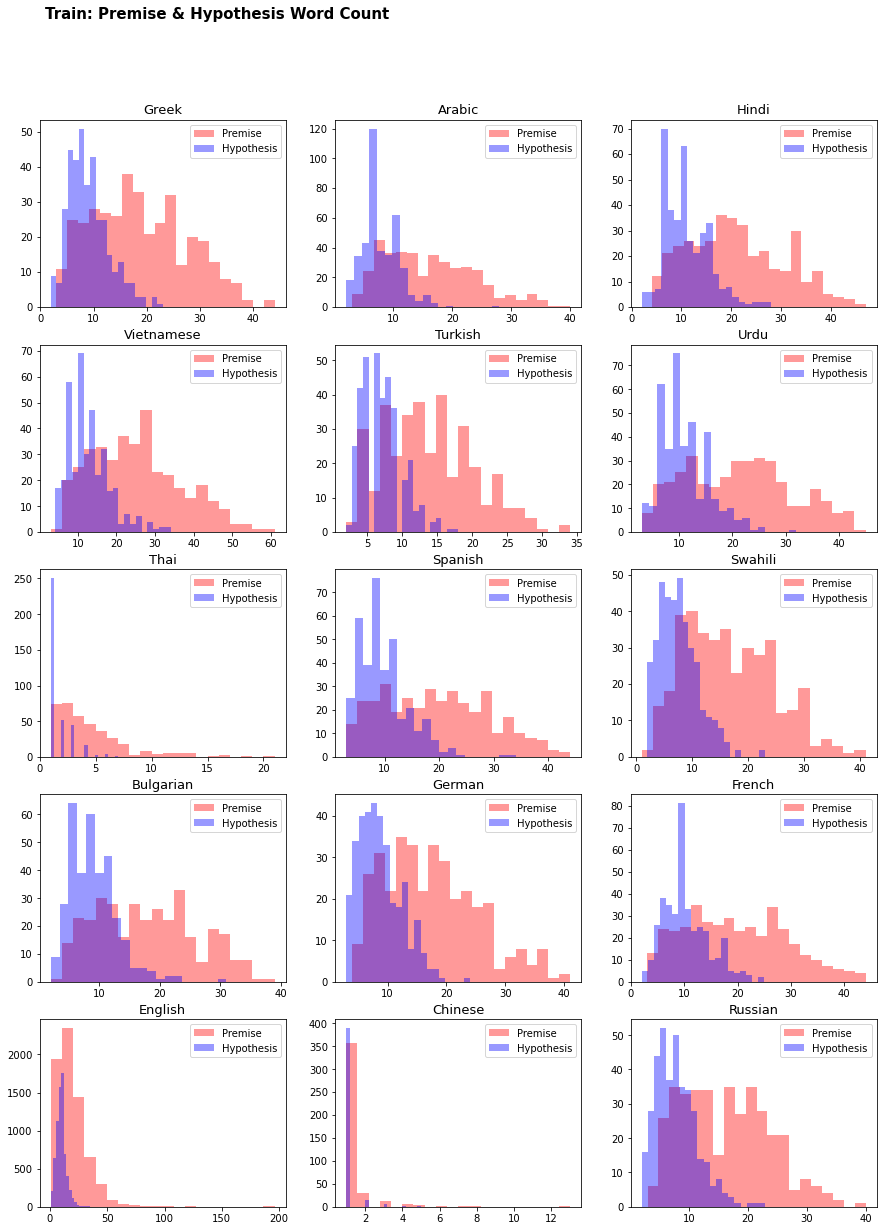

In [11]:
df_train['premise_word_cnt'] = df_train['premise'].apply(lambda x: len(x.split()))
df_train['hypothesis_word_cnt'] = df_train['hypothesis'].apply(lambda x: len(x.split()))

fig,ax = plt.subplots(nrows=5,ncols=3,figsize=(15,20))
for i,lang in enumerate(list(train_language_cnt.index)):
    sns.distplot(df_train[df_train.language == lang]['premise_word_cnt'],bins=20,
                 color='red',label='Premise',kde=False, ax=ax[divmod(i,3)[0],divmod(i,3)[1]])
    sns.distplot(df_train[df_train.language == lang]['hypothesis_word_cnt'],bins=20,
                 color='blue',label='Hypothesis',kde=False, ax=ax[divmod(i,3)[0],divmod(i,3)[1]])
    ax[divmod(i,3)[0],divmod(i,3)[1]].set_title(lang,fontsize=13)
    ax[divmod(i,3)[0],divmod(i,3)[1]].legend()
    ax[divmod(i,3)[0],divmod(i,3)[1]].set_xlabel('')
fig.text(0.13, 0.95, 'Train: Premise & Hypothesis Word Count', fontsize=15, fontweight='bold') 

Text(0.13, 0.95, 'Test: Premise & Hypothesis Word Count')

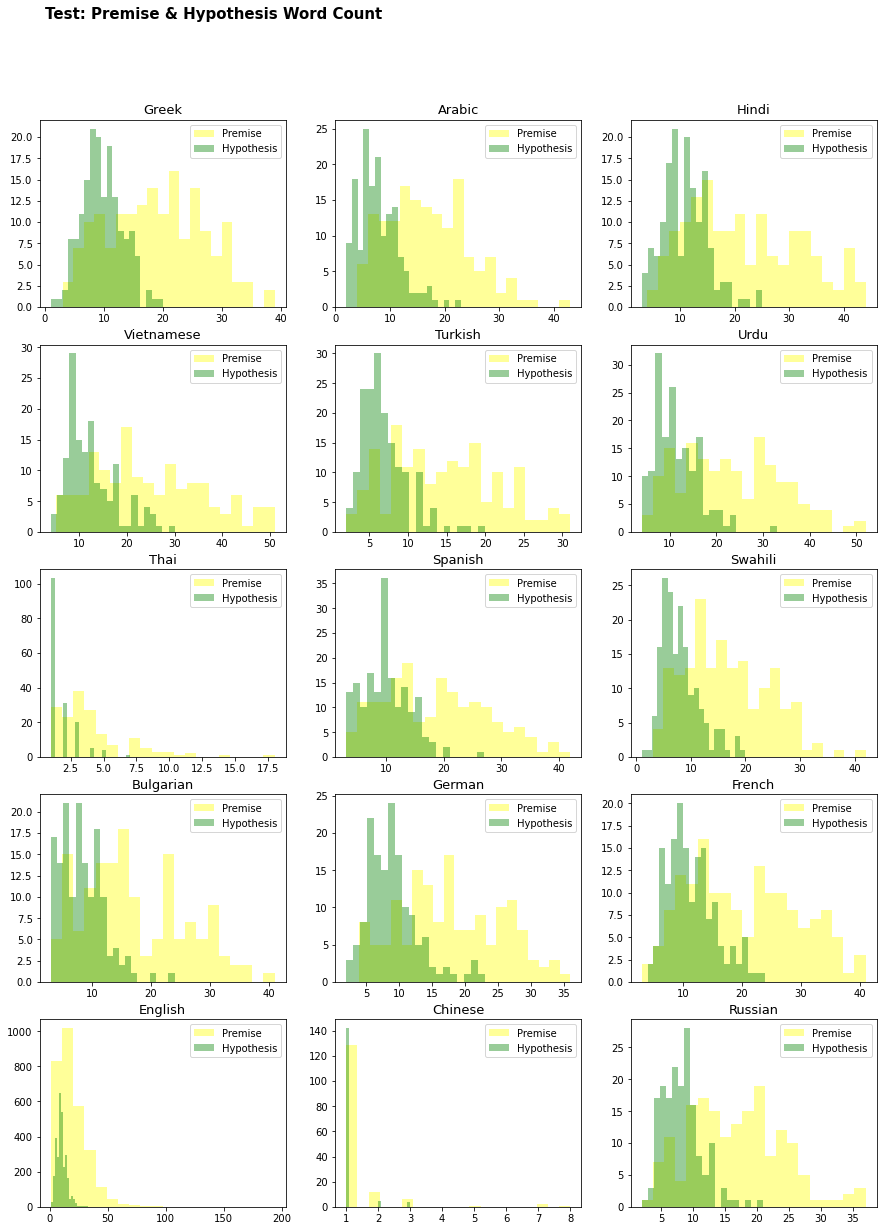

In [12]:
df_test['premise_word_cnt'] = df_test['premise'].apply(lambda x: len(x.split()))
df_test['hypothesis_word_cnt'] = df_test['hypothesis'].apply(lambda x: len(x.split()))

fig,ax = plt.subplots(nrows=5,ncols=3,figsize=(15,20))
for i,lang in enumerate(list(train_language_cnt.index)):
    sns.distplot(df_test[df_test.language == lang]['premise_word_cnt'],bins=20,
                 color='yellow',label='Premise',kde=False, ax=ax[divmod(i,3)[0],divmod(i,3)[1]])
    sns.distplot(df_test[df_test.language == lang]['hypothesis_word_cnt'],bins=20,
                 color='green',label='Hypothesis',kde=False, ax=ax[divmod(i,3)[0],divmod(i,3)[1]])
    ax[divmod(i,3)[0],divmod(i,3)[1]].set_title(lang,fontsize=13)
    ax[divmod(i,3)[0],divmod(i,3)[1]].legend()
    ax[divmod(i,3)[0],divmod(i,3)[1]].set_xlabel('')
fig.text(0.13, 0.95, 'Test: Premise & Hypothesis Word Count', fontsize=15, fontweight='bold')

In both training and test data, word count of hypothesis is less than that of premise for all the languages.

The max_len for sentences before encoding is around 60 so the in encoding phase, sequence length should be more than this value.

# Encode Input For Bert Base

Thanks to the encoding method for Bert base in toturial [notebook](https://www.kaggle.com/anasofiauzsoy/tutorial-notebook)

In [ ]:
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s))
    tokens.append('[SEP]')
    return tokenizer.convert_tokens_to_ids(tokens)

In [ ]:
def bert_encode(premise, hypothesis, tokenizer):
    
    sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(premise)])
    sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypothesis)])
    
    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*(sentence1.shape[0])
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

    input_masks = tf.ones_like(input_word_ids).to_tensor()

    type_cls = tf.zeros_like(cls)
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

    inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_masks': input_masks,
      'input_type_ids': input_type_ids}
    
    return inputs

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
train_input = bert_encode(df_train.premise.values, df_train.hypothesis.values, tokenizer)
#train_label = tf.keras.utils.to_categorical(df_train.label.values)

# Build Bert Baseline

In [16]:
K.clear_session()

In [17]:
def build_bert_baseline(max_len=80):
    bert_layer = TFBertModel.from_pretrained('bert-base-multilingual-cased')
    input_word_ids = tf.keras.Input(shape = (max_len,),dtype =tf.int32, name='input_word_ids')
    input_masks = tf.keras.Input(shape = (max_len,),dtype =tf.int32, name='input_masks')
    input_type_ids = tf.keras.Input(shape = (max_len,),dtype =tf.int32, name='input_type_ids')
    
    sequence_output = bert_layer([input_word_ids, input_masks, input_type_ids])[0]
    #sequence_output = clf_output[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(sequence_output[:,0,:])
    
    model = tf.keras.Model(inputs=[input_word_ids,input_masks,input_type_ids],outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=3e-5),
                  loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model

In [18]:
model = build_bert_baseline(max_len=80)
#for layer in model.layers:
    #print(layer.output_shape)
    
filepath='best_weight.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                                save_best_only=True, save_weights_only=True, 
                                                mode='min',save_freq = 'epoch')
#model.fit(train_input, df_train.label.values, epochs =3, 
#          batch_size = 16, callbacks=[checkpoint], validation_split=0.2)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 80)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 80, 768), (N 177853440   input_word_ids[0][0]             
                                                                 input_masks[0][0]            

# Build Bert with LSTM Head and Concat Pooling Result

Model idea from [here](https://keras.io/examples/nlp/semantic_similarity_with_bert/)

In [19]:
K.clear_session()

In [20]:
def build_bert_LSTM_head(max_len=80):
    bert_layer = TFBertModel.from_pretrained('bert-base-multilingual-cased')
    input_word_ids = tf.keras.Input(shape = (max_len,),dtype =tf.int32, name='input_word_ids')
    input_masks = tf.keras.Input(shape = (max_len,),dtype =tf.int32, name='input_masks')
    input_type_ids = tf.keras.Input(shape = (max_len,),dtype =tf.int32, name='input_type_ids')
    
    sequence_output = bert_layer([input_word_ids, input_masks, input_type_ids])[0]
    bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(sequence_output)
    avg_pool = tf.keras.layers.GlobalAveragePooling1D()(bi_lstm)
    max_pool = tf.keras.layers.GlobalMaxPooling1D()(bi_lstm)
    concat = tf.keras.layers.concatenate([avg_pool, max_pool])
    dropout = tf.keras.layers.Dropout(0.3)(concat)
    output = tf.keras.layers.Dense(3, activation="softmax")(dropout)
     
    model = tf.keras.Model(inputs=[input_word_ids,input_masks,input_type_ids],outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=3e-5),
                  loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model

In [21]:
bert_lstm_model = build_bert_LSTM_head(max_len=80)
#for layer in model.layers:
    #print(layer.output_shape)
    
filepath='LSTM_best_weight.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                                save_best_only=True, save_weights_only=True, 
                                                mode='min',save_freq = 'epoch')
#bert_lstm_model.fit(train_input, df_train.label.values, epochs =2, 
#          batch_size = 16, callbacks=[checkpoint], validation_split=0.2)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 80)]         0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 80)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 80, 768), (N 177853440   input_word_ids[0][0]             
                                                                 input_masks[0][0]            

The model performance did not improve after increasing complexity compared with baseline Bert model. Hence, There are two choices for me to boosting my results. The first is to do some translation augmentation and train the model again. The second is to switch to roBerta model.

# XLM-roBerta-Large

Thanks to the [notebook](https://www.kaggle.com/xhlulu/contradictory-watson-concise-keras-xlm-r-on-tpu) as a complete guidance on TPU configuration and XLM-roBerta-Large fine tuning

In [22]:
K.clear_session()

Initialize TPU

In [9]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [6]:
def roberta_encode(text,tokenizer,max_len=80):
    encoded_text = tokenizer.batch_encode_plus(text,
                                               pad_to_max_length=True,
                                               max_length=max_len)
    return encoded_text

In [7]:
tokenizer = AutoTokenizer.from_pretrained('jplu/tf-xlm-roberta-large')

train_text = df_train[['premise', 'hypothesis']].values.tolist()
encoded_train_text = roberta_encode(train_text,tokenizer,max_len=80)

In [8]:
x_train, x_valid, y_train, y_valid = train_test_split(
    encoded_train_text['input_ids'], 
    df_train.label.values, 
    test_size=0.2, random_state=98)

In [10]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE

In [11]:
def create_tf_dataset(X, y,val,batch_size= BATCH_SIZE,auto=AUTO):
    
    dataset = tf.data.Dataset.from_tensor_slices((X,y)).shuffle(98)
          
    if not val:
        dataset = dataset.repeat().batch(batch_size).prefetch(auto)
    else:
        dataset = dataset.batch(batch_size).prefetch(auto)

    return dataset

In [12]:
tf_train_dataset = create_tf_dataset(x_train,y_train,val=False)
tf_val_dataset = create_tf_dataset(x_valid,y_valid,val=True)

In [13]:
tf_train_dataset,tf_val_dataset

(<PrefetchDataset shapes: ((None, 80), (None,)), types: (tf.int32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 80), (None,)), types: (tf.int32, tf.int64)>)

In [14]:
def build_roberta(max_len=80):
    roberta_layer = TFAutoModel.from_pretrained('jplu/tf-xlm-roberta-large')
    input_ids = tf.keras.Input(shape = (max_len,),dtype =tf.int32, name='input_ids')
    
    sequence_output = roberta_layer(input_ids)[0]
    #sequence_output = clf_output[0]
    output = tf.keras.layers.Dense(3, activation='softmax')(sequence_output[:,0,:])
    
    model = tf.keras.Model(inputs=input_ids, outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5),
                  loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    print(model.summary())
    return model

In [15]:
with strategy.scope():    
    roberta_model = build_roberta(max_len=80)
    #for layer in model.layers:
        #print(layer.output_shape)

    filepath='roberta_best_weight.hdf5'
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                                    save_best_only=True, save_weights_only=True, 
                                                    mode='min',save_freq = 'epoch')
    #roberta_model.fit(tf_train_dataset, epochs =10, 
              #batch_size = 16, callbacks=[checkpoint], validation_data=tf_val_dataset)
    n_steps = len(x_train)//BATCH_SIZE
    roberta_model.fit(tf_train_dataset,steps_per_epoch=n_steps,
                      validation_data=tf_val_dataset,callbacks=[checkpoint],epochs=10)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 80)]              0         
_________________________________________________________________
tf_roberta_model (TFRobertaM ((None, 80, 1024), (None, 559890432 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 1024)]            0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 559,893,507
Trainable params: 559,893,507
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


75/75 [==============================] - ETA: 0s - accuracy: 0.3480 - loss: 1.2074
Epoch 00001: val_loss improved from inf to 1.04725, saving model to roberta_best_weight.hdf5
75/75 [==============================] - 101s 1s/step - accuracy: 0.3480 - loss: 1.2074 - val_accuracy: 0.4418 - val_loss: 1.0473
Epoch 2/10
75/75 [==============================] - ETA: 0s - accuracy: 0.5173 - loss: 0.9683
Epoch 00002: val_loss improved from 1.04725 to 0.76936, saving model to roberta_best_weight.hdf5
75/75 [==============================] - 32s 432ms/step - accuracy: 0.5173 - loss: 0.9683 - val_accuracy: 0.6757 - val_loss: 0.7694
Epoch 3/10
75/75 [==============================] - ETA: 0s - accuracy: 0.7030 - loss: 0.7058
Epoch 00003: val_loss improved from 0.76936 to 0.61566, saving model to roberta_best_weight.hdf5
75/75 [==============================] - 33s 446ms/step - accuracy: 0.7030 - loss: 0.7058 - val_accuracy: 0.7488 - val_loss: 0.6157
Epoch 4/10
75/75 [==============================

# Cross Validation Score

In [ ]:
def model_cv_score(model):    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=98)
    E_cv = 0
    for fold,(train_idx,val_idx) in enumerate(skf.split(df_train['premise'],df_train['label'])):
        print('\nFold %s:'% (fold))
        K.clear_session()

        train_premise = df_train['premise'].iloc[train_idx]
        train_hypothesis = df_train['hypothesis'].iloc[train_idx]
        train_label = df_train['label'].iloc[train_idx]

        val_premise = df_train['premise'].iloc[val_idx]
        val_hypothesis = df_train['hypothesis'].iloc[val_idx]
        val_label = df_train['label'].iloc[val_idx]
        
        ## use encode method you define, this method is for bert base and 
        ## subject to change when switched to roBerta
        cv_train_input = bert_encode(train_premise.values, train_hypothesis.values, tokenizer)
        cv_val_input = bert_encode(val_premise.values, val_hypothesis.values, tokenizer)

        #model = build_bert(max_len=55)
        filepath='best_weight_fold%s.h5'%(fold)
        checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                                                    save_best_only=True, save_weights_only=True, 
                                                    mode='min',save_freq = 'epoch')
        model.fit(cv_train_input, train_label.values, epochs =2, 
              batch_size = 16, callbacks=[checkpoint], 
              validation_data=(cv_val_input,val_label.values))

        print('\nPredicting OOF Error......')
        model.load_weights('best_weight_fold%s.h5'%(fold))
        val_pred = [np.argmax(p) for p in model.predict(cv_val_input)]
        oof_error = np.sum([pred!=true for pred,true in zip(val_pred,val_label)])/len(val_label)
        print('Fold_%s Error: %s' % (fold,oof_error))
        E_cv += oof_error

    print('\nE_cv = %s'%(E_cv/5))

Unbiased prediction of out of sample error for bert baseline is 0.35825. The best model performance is fold 0.

# Submission

In [ ]:
#test_input = bert_encode(df_test.premise.values, df_test.hypothesis.values, tokenizer)
#model.load_weights('./best_weight_fold0.h5')
#pred = [np.argmax(res) for res in model.predict(test_input)]

In [16]:
test_text = df_test[['premise', 'hypothesis']].values.tolist()
encoded_test_text = roberta_encode(test_text,tokenizer,max_len=80)
tf_test_dataset = (tf.data.Dataset
                .from_tensor_slices(encoded_test_text['input_ids'])
                .batch(BATCH_SIZE))
roberta_model.load_weights('./roberta_best_weight.hdf5')
pred = [np.argmax(res) for res in roberta_model.predict(tf_test_dataset)]

In [17]:
submission = pd.DataFrame({'id':df_test.id,'prediction':pred})
submission.to_csv('submission.csv',index=False)

In [18]:
submission.head(10)

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,0
5,aa2510d454,1
6,865d1c7b16,1
7,a16f7ed56b,0
8,6d9fa191e6,1
9,c156e8fed5,2
